In [ ]:
import simphony.libraries.siepic as siepic
import simphony.libraries.analytic as analytic
import matplotlib.pyplot as plt
from simphony.time_domain.utils import gaussian_pulse
from functools import partial

netlist={
    "instances": {
        "laser":"laser",
        "wg1": "waveguide",
    },
    "connections": {
        "laser,o0": "wg1,o0",
    },
    "ports": {
        "laser_output": "laser,o0",
        "waveguide_output": "wg1,o1",
    }
}

models={
    "laser": analytic.CWLaser,
    # "laser": analytic.OpticalSource,
    "waveguide": siepic.waveguide,
    # "waveguide": analytic.Waveguide,
}

pulse_fn = partial(gaussian_pulse, t0=4e-12, sigma=1e-12)
settings={ 
    "laser": {"wavelength": 1.55e-6},
    # "laser": {"wavelength": 1.55e-6, "envelope_fn": pulse_fn},
    "wg1": {"length":6},
}

In [6]:
from simphony.circuit import Circuit
ckt = Circuit(netlist, models)
ckt.display(inline=True)

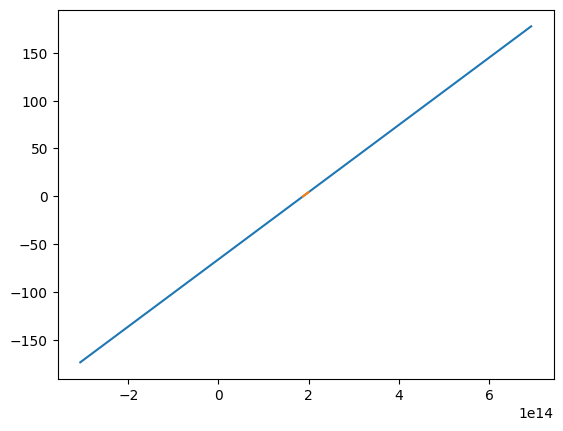

NUMBER OF POLES: 32


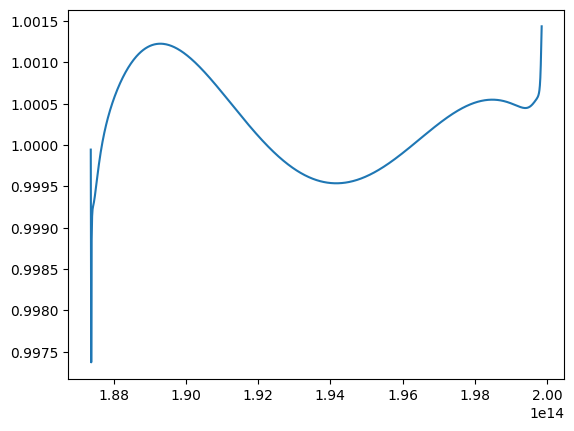

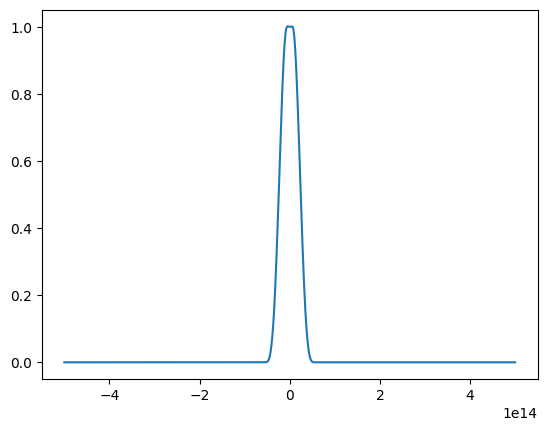

In [7]:
from simphony.simulation import SampleModeSimulation, SampleModeSimulationParameters
import numpy as np

wl = 1e-6*np.linspace(1.5, 1.6, 1000)
sms = SampleModeSimulation(ckt)
sms_result = sms.run(settings=settings, use_jit=True)

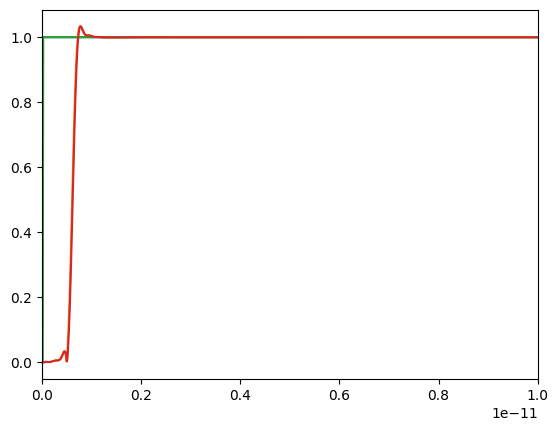

In [8]:
laser_output = sms_result['laser']['o0']
adv0_output = sms_result['_optical_advance0']['out']
adv1_output = sms_result['_optical_advance1']['in']
wg_output = sms_result['wg1']['o1']
t = np.arange(len(laser_output.amplitude[:, 0, 0]))
t = t*1e-14
plt.plot(t[:], np.abs(laser_output.amplitude[:, 0, 0]))
plt.plot(t[:], np.abs(wg_output.amplitude[:, 0, 0]))
plt.plot(t[:], np.abs(adv0_output.amplitude[:, 0, 0]))
plt.plot(t[:], np.abs(adv1_output.amplitude[:, 0, 0]))

plt.xlim([0, 1e-11])
plt.axvline()

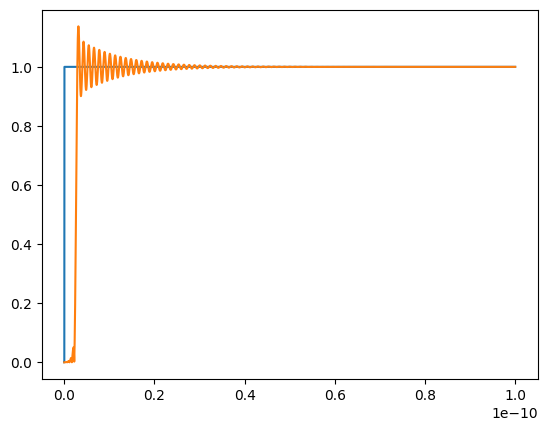

In [56]:
def compute_group_delay(wavelengths, s_params):
    # Unwrap phase
    phase = np.unwrap(np.angle(s_params))  # radians

    # Derivative of phase w.r.t wavelength
    dphi_dlambda = np.gradient(phase, wavelengths)  # radians per meter

    # Compute group delay
    c = 299792458  # speed of light in m/s
    group_delay = -dphi_dlambda * (wavelengths**2) / (2 * np.pi * c)  # in seconds

    return group_delay  # same length as input

S = siepic.waveguide(wl=np.linspace(1.5, 1.6, 1000), length=100)[('o0', 'o1')]

tau1 = compute_group_delay(wl, S)[500]
tau2 = 4e-12
plt.plot(t, np.abs(laser_output.amplitude[:, 0, 0]))
plt.plot(t, np.abs(wg_output.amplitude[:, 0, 0]))
# plt.axvline(tau1+tau2+.5*0*1e-12)
# plt.axvline(tau1+tau2+.5*1*1e-12)
# plt.axvline(tau1+tau2+.5*2*1e-12)
# plt.axvline(tau1+tau2+.5*3*1e-12)
# plt.axvline(tau1+tau2+.5*4*1e-12)

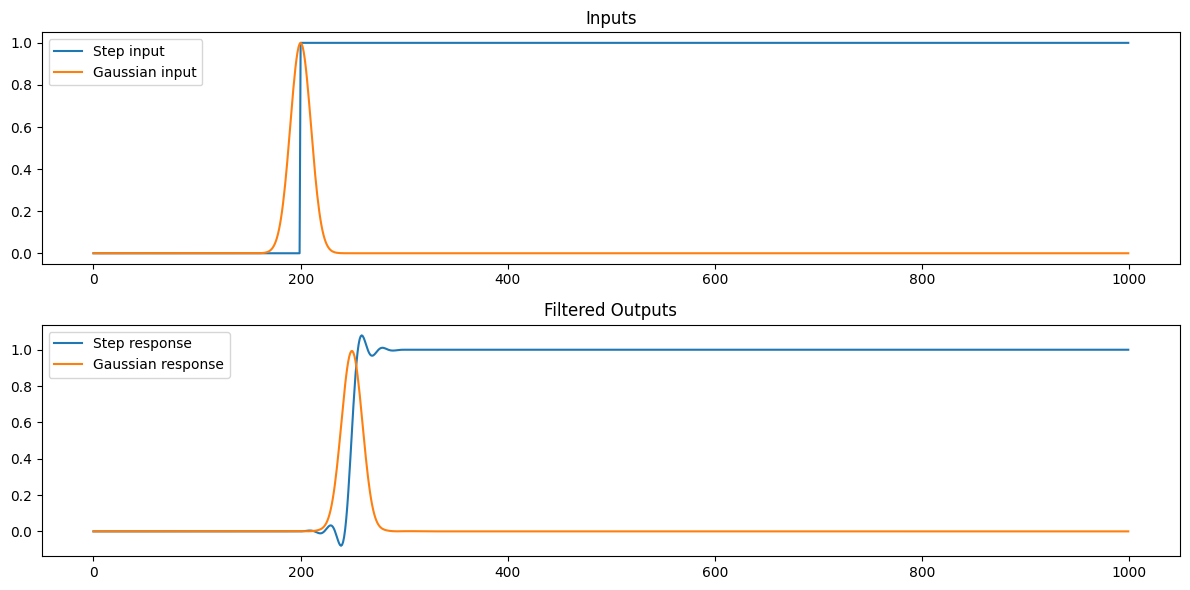

In [32]:
import matplotlib.pyplot as plt
from scipy.signal import firwin
import numpy as np

# FIR filter
L = 100
h = firwin(L, 0.1)

# Inputs
N = 1000
tau = 200
sigma = 10

step_input = np.zeros(N)
step_input[tau:] = 1.0

n = np.arange(N)
gaussian_input = np.exp(-0.5 * ((n - tau) / sigma) ** 2)

# Filter outputs
step_response = np.convolve(step_input, h, mode='full')[:N]
gaussian_response = np.convolve(gaussian_input, h, mode='full')[:N]

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("Inputs")
plt.plot(step_input, label="Step input")
plt.plot(gaussian_input, label="Gaussian input")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Filtered Outputs")
plt.plot(step_response, label="Step response")
plt.plot(gaussian_response, label="Gaussian response")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.signal import bessel, freqz, tf2zpk

# === 1. Bessel Filter Design ===
order = 5
cutoff = 0.02  # Normalized frequency (0.5 = Nyquist)
b, a = bessel(order, cutoff, btype='low', analog=False, norm='phase')

# === 2. Group Delay Calculation ===
w, h = freqz(b, a, worN=2048)
freq = w / jnp.pi  # Normalized frequency [0, 1]
phase = jnp.unwrap(jnp.angle(h))
group_delay_bessel = -jnp.gradient(phase) / jnp.gradient(w)

# === 3. Design a Simple All-Pass Filter for Compensation ===
# First-order all-pass: H(z) = (a + z^-1) / (1 + a z^-1)
# We'll pick 'a' close to 1 to give more delay at higher frequencies

a1 = 0.01
b_ap = jnp.array([a1, 1.0])
a_ap = jnp.array([1.0, a1])

# Frequency response of the all-pass
_, h_ap = freqz(b_ap, a_ap, worN=2048)
phase_ap = jnp.unwrap(jnp.angle(h_ap))
group_delay_ap = -jnp.gradient(phase_ap) / jnp.gradient(w)

# === 4. Cascade Bessel + All-Pass ===
from scipy.signal import convolve

b_total = convolve(b, b_ap)
a_total = convolve(a, a_ap)

_, h_total = freqz(b_total, a_total, worN=2048)
phase_total = jnp.unwrap(jnp.angle(h_total))
group_delay_total = -jnp.gradient(phase_total) / jnp.gradient(w)

# === 5. Plot Group Delays ===
plt.figure(figsize=(10, 6))
plt.plot(freq, group_delay_bessel, label='Bessel Filter')
plt.plot(freq, group_delay_ap, label='All-Pass Compensation')
plt.plot(freq, group_delay_total, label='Cascaded (Flattened)')
plt.xlim(0, 0.05)
plt.xlabel('Normalized Frequency (π radians/sample)')
plt.ylabel('Group Delay (samples)')
plt.title('Group Delay Compensation using All-Pass Filter')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.signal import butter, bessel, group_delay
import matplotlib.pyplot as plt

# Example: design and compare filters
fs = 1000  # Hz
N = 5     # order
fc = 100   # cutoff

# Design Butterworth and Bessel filters
b_butter, a_butter = butter(N, fc/(fs/2))
b_bessel, a_bessel = bessel(N, fc/(fs/2), analog=False)

# Compute group delay
w_b, gd_b = group_delay((b_butter, a_butter), fs=fs)
w_be, gd_be = group_delay((b_bessel, a_bessel), fs=fs)

# Plot
plt.plot(w_b, gd_b, label="Butterworth")
plt.plot(w_be, gd_be, label="Bessel")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Group Delay [s]")
plt.title("Group Delay vs Frequency")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from simphony.utils import dict_to_matrix

In [ ]:
from simphony.signals import sample_mode_electrical_signal, sample_mode_optical_signal
pm1_inputs = {
    'e0': sample_mode_electrical_signal(field=[0.00, 10.0], wl=[1.55e-6, 1.57e-6]),
    'o0': sample_mode_optical_signal(field=[0.50, 1.00], wl=[1.55e-6, 1.56e-6]),
    'o1': sample_mode_optical_signal(field=[0.50, 1.00], wl=[1.55e-6, 1.56e-6]),
}

sms.components['pm1'].step()

In [ ]:
from simphony.signals import sample_mode_optical_signal, sample_mode_electrical_signal
my_signals = {
    'o0': sample_mode_optical_signal(),
    'e0': sample_mode_electrical_signal(),
}

In [ ]:
new_field = my_signals['o0'].field.at[0, 0].set(1.0 + 0.5j)
my_signals['o0'].replace(field=new_field)

In [ ]:
import jax

@jax.jit
def my_function(new_value):
    new_field = my_signals['o0'].field.at[0, 0].set(new_value)
    my_signals['o0'].replace(field=new_field)

In [ ]:
my_function(0.1)

In [ ]:
for i in range(100000):
    my_function(i)

In [ ]:
import simphony.libraries.siepic as siepic
import simphony.libraries.analytic as analytic
import matplotlib.pyplot as plt

netlist={
    "instances": {
        "laser":"laser",
        "splitter":"ybranch",
        "combiner": "ybranch",  
        "top1": "waveguide",
        "top2": "waveguide",
        "bot1": "waveguide",
        "bot2": "waveguide",
        # "phase_modulator": "phase_modulator",
        "pm1": "phase_modulator",
        "pm2": "phase_modulator",

        "vs1": "voltage_source",
        "vs2": "voltage_source",
        # "vf": "voltage_follower",
        # "vf1": "voltage_follower",
        # "vf2": "voltage_follower",
        # "prng": "prng",

        # "pm2": "phase_modulator",
        # "vs2": "voltage_source",

        # "y1": "ybranch",
        # "y2": "ybranch",
    },
    "connections": {
        "laser,o0": "splitter,port_1",
        "splitter,port_2":"top1,o0",
        "splitter,port_3":"bot1,o0",
        "top2,o1":"combiner,port_2",   
        "bot2,o1": "combiner,port_3",
        
        "top1,o1":"pm1,o0",
        "pm1,o1":"top2,o0",
        "bot1,o1":"pm2,o0",
        "pm2,o1":"bot2,o0",
        
        # Should Work
        "vs1,e0":"pm1,e0",
        "vs2,e0":"pm2,e0",

        # Should Not Work
        # "pm1,e0":"vf,e0",
        # "vf,e1":"pm2,e0",
        
        # Multiple connections, same nodes
        # "y1,port_2": "y2,port_2",
        # "y1,port_3": "y2,port_3",

        # Invalid Connection
        # "vs2,e0":"pm2,o0",
    },
    "ports": {
        "in": "splitter,port_1",
        "out": "combiner,port_1",
    }
}

models={
    "laser": analytic.CWLaser,
    "ybranch": siepic.y_branch,
    # "ybranch": analytic.optical_s_parameter(siepic.y_branch),
    "waveguide": siepic.waveguide,
    "phase_modulator": analytic.OpticalModulator,
    "voltage_source": analytic.VoltageSource,
    # "prng": analytic.PRNG,
    # "voltage_follower": analytic.VoltageFollower,
}

settings={ 
    # "splitter": {"bad_setting": 10},
    "laser": {"wavelength": 1.55e-6},
    "top1": {"length": 20},
    "top2": {"length": 20},
    "bot1": {"length": 20},
    "bot2": {"length": 20},    
    "vs1": {"steady_state_voltage": 1.0, "steady_state_wl": 0},
    "vs2": {"steady_state_voltage": 0.0, "steady_state_wl": 0}
}
